# GROUP - 15

# 19CE10035 Kamal Kyal

# 19EC39045 Rishi Suman

# 22CS60R37 Shailesh Chaudhary

# Project Code: PBSVM

# Predict Behavior using Support Vector Machines


#**Making Changes to the Dataset to use it in further analysis.**

**Importing the Libraries which we are allowed to use. (Section of Code taken from the Problem Statement)**

In [1]:
import numpy as np
import csv 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn import metrics
import operator
from math import log
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.svm import SVC

**Read in the dataset and perform basic exploratory analysis**

In [2]:
# Loading the dataset
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
#Checking the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

**Storing the Labels for Plotting the Samples towards the Later Parts of the Code**

In [4]:
labels = df["Churn"].values # as numpy array
print(labels)

[False False False ... False False False]


**Removing Spaces from Column Names in the Dataset**

In [5]:
# Function to clean column names
def column_name_remove_space(df):
    for x in df.columns:
        if " " in x:
            df = df.rename(columns={x:x.replace(" ","_").replace("(","")
                                    .replace(")","").replace(",","_").replace("/","_")})
    return df

**Removing Object datatype Columns from the Dataset as these are not important for Principal Component Analysis. Labels are also removed as they are also not important in PCA.**

In [6]:
# Following data columns are not important for data analysis (categorical data, geolocation data etc)
to_drop = ['State','International_plan','Voice_mail_plan', 'Churn']

# Fix all columns
data = column_name_remove_space(df)

#Removing the Columns mentioned under to_drop list
data.drop(columns=to_drop,inplace=True)

In [7]:
# Check for null values
data.isna().any(axis=0).any()

False

**Final Dataset to be used for PCA/LDA Analysis**

In [8]:
data.head()

,Account_length,Area_code,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


**Saving it as a .csv file**

In [9]:
data.to_csv('PCA_data.csv')

# **Principal Component Analysis**

1.   Here, X is the data matrix with shape (number_of_samples, number_of_features) and labels is the array of class labels with shape (number_of_samples,).

2.    We Scale the data before applying PCA so that no feature dominates. When dealing with data that has features with different scales, it's often important to scale the data first. This is because data that has larger values may sway the data even with relatively little variability

3.    We center the data by subtracting the mean of each feature from each data point.

4.   We then compute the covariance matrix and its eigenvalues and eigenvectors using NumPy's np.cov() and np.linalg.eig() functions, respectively. 

5.   We sort the eigenvalues and eigenvectors in descending order, and project the data onto the first two principal components (In the direction of the Maximum and 2nd Largest Eigenvalues). 

6.   Finally, we plot the reduced dimensional data using Matplotlib's plt.scatter() function, with colors assigned based on the class labels using a dictionary.

In [10]:
X = data
X.shape

(3333, 16)

In [11]:
mean_ = X.mean(axis =0)
std_ = X.std(axis=0)

X_std =  (X-mean_)/std_
#print (X_std[0:5])
print ("The shape of Feature Matrix is ",X_std.shape)

The shape of Feature Matrix is  (3333, 16)


In [12]:
# Center the data
X_mean = np.mean(X_std, axis=0)
X_centered = X_std - X_mean
cov_mat = np.cov(X_centered.T)
print(cov_mat.shape)

(16, 16)


In [13]:
# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

In [14]:
# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

In [15]:
# Project the data onto the first two principal components
X_pca = X_centered @ eigenvectors[:, :2]
print(X_pca)

             0         1
0     1.661432  0.560340
1    -0.852726  1.208163
2    -0.995789  0.690156
3     1.623030  2.234203
4    -0.670119  0.925866
...        ...       ...
3328  0.799500  1.179937
3329  0.468681  0.506771
3330 -0.764963 -1.976116
3331  1.216102 -0.463496
3332  0.447554 -0.792713

[3333 rows x 2 columns]


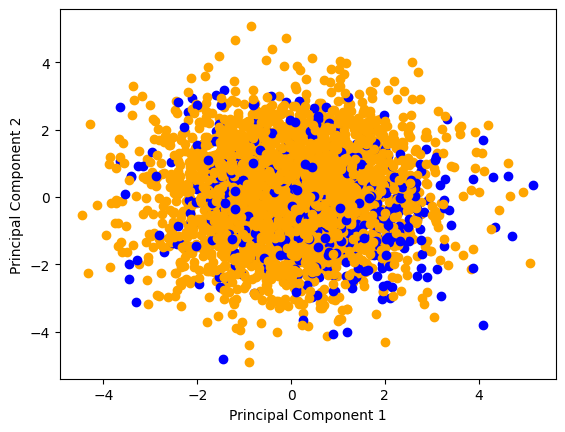

In [16]:
# Plot the reduced dimensional data
colors = {0: 'orange', 1: 'blue'}

for i in range(len(X_pca)):
    plt.scatter(X_pca[0][i], X_pca[1][i], color=colors[labels[i]])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# **Comparison of my PCA Plot with the inbuilt PCA Available in sklearn**

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Instantiate PCA object with 2 components
pca = PCA(n_components=2)

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_std)

# Transform the test data
X_test_pca = pca.transform(X_std)

print(X_train_pca)

[[ 1.66143163  0.56034048]
 [-0.852726    1.20816323]
 [-0.99578875  0.69015581]
 ...
 [-0.76496312 -1.9761156 ]
 [ 1.21610224 -0.46349569]
 [ 0.44755373 -0.79271329]]


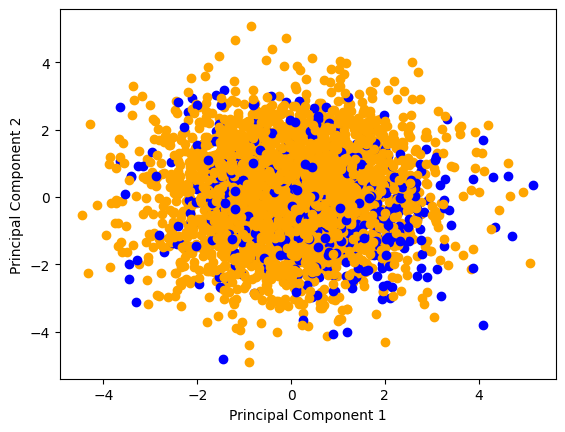

In [18]:
import matplotlib.pyplot as plt

# Set up a dictionary to map class labels to colors
colors = {0: 'orange',  1: 'blue'}

# Plot the reduced dimensional data
for i in range(len(X_train_pca)):
    plt.scatter(X_train_pca[i, 0], X_train_pca[i, 1], color=colors[labels[i]])
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# **SVM**

various parameters to tune the SVM

1.   C: float, default=1.0. Regularization parameter. The penalty is inversely proportional to C, a squared l2 penalty.
2.   kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
3.   gamma: {‘scale’, ‘auto’} or float, default=’scale’

if gamma='scale' (default) = 1 / (n_features * X.var())

if ‘auto’ = 1 / n_features



In [19]:
# parameter space for hypertunning the svm model
C_list = [1.0, 10.0]
kernel_list = ['linear', 'poly', 'rbf']
gamma_list = ['scale', 'auto'] 

# initializing the table for records of validation and test accuracies on dataset
test_records = pd.DataFrame([], columns=['data','C','kernel','gamma','score'])
records = pd.DataFrame([], columns=['data','C','kernel','gamma','score'])
indx = 0
ind = 0

In [20]:
def divide_data(df):
  """
  takes in the input dataframe 
  divides into train, validation and test sets
  and outputs the corresponding X and y columns
  """
  data_train = df[:int(0.7*len(df))]
  data_val = df[int(0.7*len(df)):int(0.8*len(df))]
  data_test = df[int(0.8*len(df)):]

  X_train = data_train.drop(columns=['target'])
  X_val = data_val.drop(columns=['target'])
  X_test = data_test.drop(columns=['target'])
  y_train = data_train['target']
  y_val = data_val['target']
  y_test = data_test['target']
  return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
def svm_hypertunning(text, X_data, indx, ind, records, test_records):
  """
  takes in input parameters of 
  1. the type of dataset used in recording performance entry
  2. dataset for training, validation and test metric generation
  3. indices for inputing in recorded table for validation scores
  4. indices for inputing in recorded table for test scores of best performing on validation model
  5. table for storing validation scors
  5. table for storing test scores
  """
  # combining the preprocessed features with the corresponding labels
  df = pd.DataFrame(X_data)
  df['target'] = labels
  df = df.sample(frac=1).reset_index(drop=True) # random shuffle data
  # dividing into train, validation and test sets
  X_train, y_train, X_val, y_val, X_test, y_test = divide_data(df)

  # indicator for maintaining the best performing model on validation set
  max_score = 0

  for i in range(len(C_list)):
    for j in range(len(kernel_list)):
      for k in range(len(gamma_list)):
        # iterating each SVM for each parameter search
        model = SVC(C=C_list[i], kernel=kernel_list[j], gamma=gamma_list[k])
        # training the model on training dataset
        model.fit(X_train, y_train)
        # predicting the results on validation dataset
        y_pred = model.predict(X_val)
        # calculating the accuracy score 
        score = accuracy_score(y_val, y_pred)

        if(score > max_score): 
          # if it surpasses to be the best scoring model, then saving the model and corresponding parameters used
          param = []
          model_final = model
          param.append(C_list[i]) 
          param.append(kernel_list[j])
          param.append(gamma_list[k])
        
        # saving the scores along with corresponding parameters in validation table
        records.loc[indx,'C'] = C_list[i]
        records.loc[indx,'kernel'] = kernel_list[j]
        records.loc[indx,'gamma'] = gamma_list[k]
        records.loc[indx,'score'] = score
        records.loc[indx,'data'] = text
        print(C_list[i], kernel_list[j], gamma_list[k])
        indx+=1
    
  # predicting on the test set using the best performing model on validation set
  y_pred = model_final.predict(X_test)
  score = accuracy_score(y_test, y_pred)

  # saving the scores along with corresponding best parameters in test table
  test_records.loc[ind,'C'] = param[0]
  test_records.loc[ind,'kernel'] = param[1]
  test_records.loc[ind,'gamma'] = param[2]
  test_records.loc[ind,'score'] = score
  test_records.loc[ind,'data'] = text
  ind+=1
  
  # returing the next indices to be filled
  return indx, ind

In [22]:
# running for various parameters of SVM on custom PCA DATASET 
indx, ind = svm_hypertunning("custom PCA data", X_pca, indx, ind, records, test_records)
# running for various parameters of SVM on inbuilt PCA DATASET 
indx, ind = svm_hypertunning("inbuilt PCA data", X_train_pca, indx, ind, records, test_records)

1.0 linear scale
1.0 linear auto
1.0 poly scale
1.0 poly auto
1.0 rbf scale
1.0 rbf auto
10.0 linear scale
10.0 linear auto
10.0 poly scale
10.0 poly auto
10.0 rbf scale
10.0 rbf auto
1.0 linear scale
1.0 linear auto
1.0 poly scale
1.0 poly auto
1.0 rbf scale
1.0 rbf auto
10.0 linear scale
10.0 linear auto
10.0 poly scale
10.0 poly auto
10.0 rbf scale
10.0 rbf auto


table containing all accuracies for validation and test on PCA dataset

In [23]:
records

,data,C,kernel,gamma,score
0,custom PCA data,1.0,linear,scale,0.858859
1,custom PCA data,1.0,linear,auto,0.858859
2,custom PCA data,1.0,poly,scale,0.858859
3,custom PCA data,1.0,poly,auto,0.858859
4,custom PCA data,1.0,rbf,scale,0.858859
5,custom PCA data,1.0,rbf,auto,0.858859
6,custom PCA data,10.0,linear,scale,0.858859
7,custom PCA data,10.0,linear,auto,0.858859
8,custom PCA data,10.0,poly,scale,0.858859
9,custom PCA data,10.0,poly,auto,0.858859


In [24]:
test_records

,data,C,kernel,gamma,score
0,custom PCA data,10.0,rbf,auto,0.856072
1,inbuilt PCA data,10.0,rbf,auto,0.838081


# **Linear Discriminant Analysis**

1.   Here, X is the data matrix with shape (number_of_samples, number_of_features) and labels is the array of class labels with shape (number_of_samples,).

2.    We Scale the data before applying LDA so that no feature dominates. When dealing with data that has features with different scales, it's often important to scale the data first. This is because data that has larger values may sway the data even with relatively little variability

3.    We compute the class means, within-class scatter matrix, and between-class scatter matrix using NumPy's np.mean(), np.dot(), np.outer(), np.cov(), and np.outer() functions, respectively.

4.  We then compute the eigenvectors and eigenvalues of the generalized eigenvalue problem using NumPy's np.linalg.eig() function. We sort the eigenvectors in descending order of eigenvalues and project the data onto the first LDA component.

5.  Finally, we plot the reduced dimensional data using Matplotlib's plt.scatter() function, with colors assigned based on the class labels using a dictionary.




  



In [25]:
X_std.shape

(3333, 16)

In [26]:
class_means = []
for c in np.unique(labels):
    X_c = X_std[labels == c]
    class_means.append(np.mean(X_c, axis=0))

In [27]:
# Compute the Total within-class scatter matrix S_w = S1 + S2
S_w = np.zeros((X_std.shape[1], X_std.shape[1]))
for c in np.unique(labels): # Iterating over the classes
    X_c = X_std[labels == c]
    mean_c = class_means[int(c)] #Class Mean
    X_c_centered = X_c - mean_c
    S_w += np.dot(X_c_centered.T, X_c_centered) # Calculating Covariance
print(S_w.shape)

(16, 16)


In [28]:
# Compute the between-class scatter matrix
overall_mean = np.mean(X_std, axis=0)
S_b = np.zeros((X_std.shape[1], X_std.shape[1]))
for c, mean in zip(np.unique(labels), class_means):
    n_c = X_std[labels == c].shape[0]
    S_b += n_c * np.outer((mean - overall_mean), (mean - overall_mean))
print(S_b.shape)

(16, 16)


In [29]:
# Compute the eigenvalues and eigenvectors of the generalized eigenvalue problem
eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(S_w) @ S_b)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Project the data onto the first LDA component
X_lda = X @ eigenvectors[:, 0]

X_lda = X_lda.astype(float)

print(X_lda)

0        74.188739
1        61.880760
2        48.794725
3         9.815544
4        52.334199
           ...    
3328     67.049610
3329     59.378043
3330    134.582768
3331     75.569186
3332    112.563778
Length: 3333, dtype: float64


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


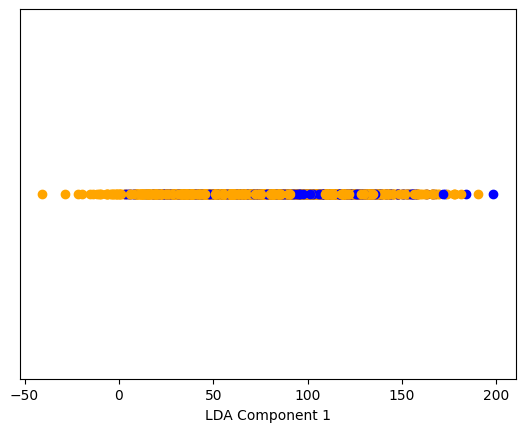

In [30]:
# Plot the reduced dimensional data
colors = {0: 'orange', 1: 'blue'}
for i in range(X_lda.shape[0]):
    plt.scatter(np.real(X_lda[i]), 0, color=colors[labels[i]])
plt.xlabel('LDA Component 1')
plt.yticks([])
plt.show()

# **Comparison of my LDA Plot with the inbuilt LDA Available in sklearn**

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Instantiate LDA object with 1 component
lda = LinearDiscriminantAnalysis(n_components=1)

# Fit and transform the training data
X_train_lda = lda.fit_transform(X_std, labels)
print(X_train_lda)

# Transform the test data
X_test_lda = lda.transform(X_std)

[[ 0.58982784]
 [-0.30186101]
 [-0.20733456]
 ...
 [ 1.06168434]
 [-0.32316976]
 [ 0.29638775]]


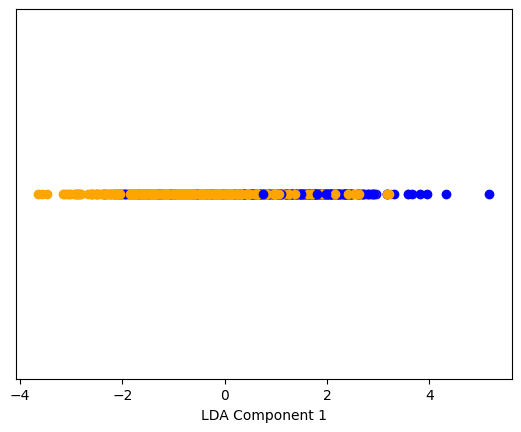

In [32]:
import matplotlib.pyplot as plt

# Set up a dictionary to map class labels to colors
colors = {0: 'orange', 1: 'blue'}

# Plot the reduced dimensional data
for i in range(len(X_train_lda)):
    plt.scatter(X_train_lda[i], 0, color=colors[labels[i]])
    
plt.xlabel('LDA Component 1')
plt.yticks([])
plt.show()

**We Observe that the Values Obtained from Custom Function and those of the inbuilt function only differ by a constant scaling of 48.8066, .i.e., Custom Values = (Inbuilt Values)/48.8066. We know that Linear Discriminant Analysis (LDA) finds it’s coefficients using the variation between the classes, so the scaling doesn’t matter.**

# **SVM**

In [33]:
# parameter space for hypertunning the svm model
C_list = [1.0, 10.0]
kernel_list = ['linear', 'poly', 'rbf']
gamma_list = ['scale']#, 'auto'] 
# by including auto parameter the code was taking a long time to run thus is commented out 

# initializing the table for records of validation and test accuracies on dataset
test_records = pd.DataFrame([], columns=['data','C','kernel','gamma','score'])
records = pd.DataFrame([], columns=['data','C','kernel','gamma','score'])
indx = 0
ind = 0

In [34]:
# running the various svm on the custom LDA DATASET 
indx, ind = svm_hypertunning("custom LDA data", X_lda, indx, ind, records, test_records)

1.0 linear scale
1.0 poly scale
1.0 rbf scale
10.0 linear scale
10.0 poly scale
10.0 rbf scale


In [35]:
# running the various svm on the inbuilt LDA DATASET (sklearn)
indx, ind = svm_hypertunning("inbuilt LDA data", X_train_lda, indx, ind, records, test_records)

1.0 linear scale
1.0 poly scale
1.0 rbf scale
10.0 linear scale
10.0 poly scale
10.0 rbf scale


table containing all accuracies for validation and test dataset

In [36]:
records

,data,C,kernel,gamma,score
0,custom LDA data,1.0,linear,scale,0.831832
1,custom LDA data,1.0,poly,scale,0.831832
2,custom LDA data,1.0,rbf,scale,0.831832
3,custom LDA data,10.0,linear,scale,0.831832
4,custom LDA data,10.0,poly,scale,0.831832
5,custom LDA data,10.0,rbf,scale,0.831832
6,inbuilt LDA data,1.0,linear,scale,0.855856
7,inbuilt LDA data,1.0,poly,scale,0.855856
8,inbuilt LDA data,1.0,rbf,scale,0.855856
9,inbuilt LDA data,10.0,linear,scale,0.855856


In [37]:
test_records

,data,C,kernel,gamma,score
0,custom LDA data,10.0,rbf,scale,0.863568
1,inbuilt LDA data,10.0,rbf,scale,0.844078
